# OCSMesh Tutorial

Import module required throughout this tutorial

In [2]:
from pathlib import Path 
import requests
import tempfile
import zipfile

import geopandas as gpd
from cartopy.feature import NaturalEarthFeature
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry

import ocsmesh

Define constants, paths, useful datasets, etc.

<AxesSubplot: >

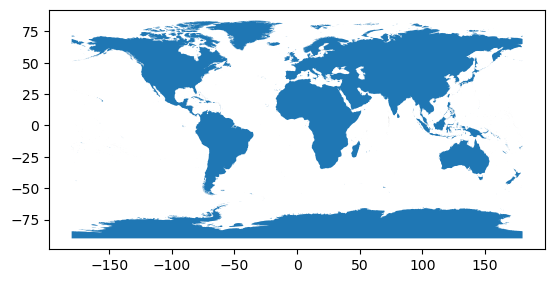

In [35]:
#gdf_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf_countries = gpd.GeoSeries(NaturalEarthFeature(category='physical', scale='10m', name='land').geometries(), crs=4326)
gdf_countries.plot()

OCSMesh generates the unstructured mesh within the **Geometry** and based on the sizes defined by the **Size function**. 
The role of the modeler is to create these two objects based on the **mesh requirements** using tools available within or even outside `ocsmesh`.

## Geometry
In the context of mesh generation using `ocsmesh`, *geometry* is the defintion of the region or domain to be meshed.
There are **3** basic ways of defining the geometry. There's also a **4th** method which is in essence *combination* of multiple of the basic types!
The jobs of OCSMesh's geometry object is to process the inputs and user specifications and eventually provide **polygons** to be meshed to the meshing engine (Jigsaw). This output polygon from the geometry is of a custom type defined by Jigsaw.

### Shape based
The most basic way for a user to define the meshing domain (i.e. geometry) is to specify a polygon or list of polygons. This way, the only thing geometry object needs to do is to pass the same input polygon to the mesh engine!

It's important to note that the **format** of input polygon and output polygon of the geometry object are **different**. The input polygon needs to be of type `shapely.geometry.Polygon` or `shapely.geometry.MultiPolygon`. *Shapely* (along with *PyGEOS*) is one the the most commonly used `GEOS` library wrappers in Python; many of the Python packages (e.g. `geopandas`) support Shapely objects, which makes is easier for the user to operate on the shapes until it meets their desired criteria, and then pass it to OCSMesh via `ShapelyGeom`.

Shape-based geometry gives the user full control on how the domain looks like. The user can manipulate the input shape, add or subtract segmets from it and then finally pass it to the `Geom` factory class to retrieve an OCSMesh geometry object:

In [74]:
gdf_oceans = gpd.GeoDataFrame(geometry=[geometry.box(*gdf_countries.total_bounds).difference(gdf_countries.unary_union)], crs=gdf_countries.crs)
roi_box = geometry.box(-74.5, 39.5, -71.5, 41.5)
gdf_roi_domain = gdf_oceans.intersection(roi_box)
geom_obj_1 = ocsmesh.Geom(gdf_roi_domain.unary_union, crs=gdf_roi_domain.crs)

Which we can plot to get the following. Note that `get_multipolygon` method returns a Shapely object, while `msh_t` returns Jigsaw polygon (used for passing info to mesh engine):

<AxesSubplot: >

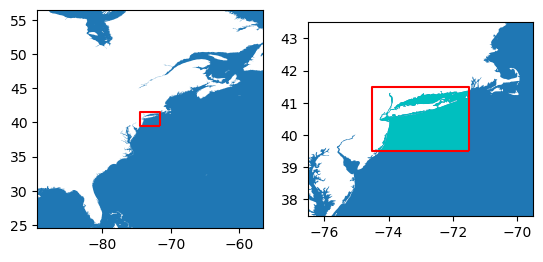

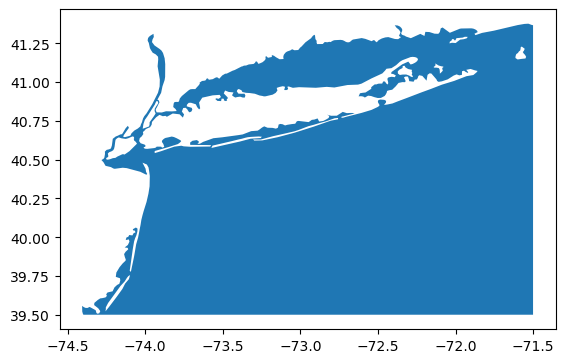

In [81]:
fig_1, axs_1 = plt.subplots(1, 2)

ax = axs_1[0]
gdf_oceans.plot(ax=ax)
gpd.GeoSeries(roi).boundary.plot(ax=ax, color='r')
ax.set_xlim(roi.bounds[0] - 15, roi.bounds[2] + 15)
ax.set_ylim(roi.bounds[1] - 15, roi.bounds[3] + 15)
ax.set_aspect(1)

ax = axs_1[1]
gdf_oceans.plot(ax=ax)
gpd.GeoSeries(roi).boundary.plot(ax=ax, color='r')
gdf_roi_domain.plot(ax=ax, color='c')
ax.set_xlim(roi.bounds[0] - 2, roi.bounds[2] + 2)
ax.set_ylim(roi.bounds[1] - 2, roi.bounds[3] + 2)
ax.set_aspect(1)


geom_poly_1 = geom_obj_1.get_multipolygon()
gpd.GeoSeries(geom_poly_1).plot()

### Mesh based

The next type of geometry definition is by mesh. That means the domain of meshing will be the same as the existing mesh that is passed as input. Let's download an example *Shinnecock Inlet* mesh from ADCIRC examples first:

In [77]:
_tmp = requests.get('https://www.dropbox.com/s/t2e26p11ep0ydx1/shinnecock_inlet_test_case.zip?dl=1')
with tempfile.NamedTemporaryFile() as tf:
    tf.write(_tmp.content)
    archive = zipfile.ZipFile(tf, 'r')
    archive.extract('fort.14')

Now we need to create a *mesh object* and then pass that mesh object to the `Geom` factory to create a geometry object based on mesh:

In [85]:
mesh_obj_2 = ocsmesh.Mesh.open('fort.14', crs=4326)
geom_obj_2 = ocsmesh.Geom(mesh_obj_2)

Now we can draw the mesh and the geometry:

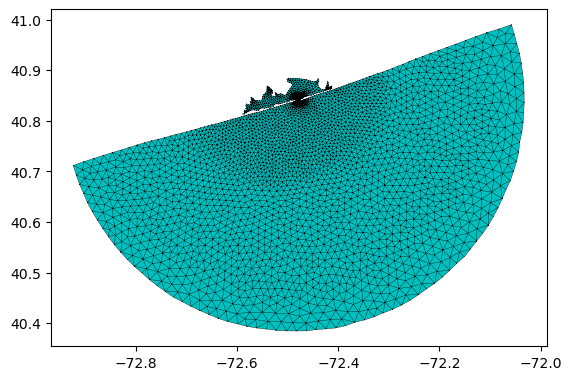

In [103]:
mesh_crd_2 = mesh_obj_2.msh_t.vert2['coord']
mesh_cnn_2 = mesh_obj_2.msh_t.tria3['index']

geom_poly_2 = geom_obj_2.get_multipolygon()

ax = gpd.GeoSeries(geom_poly_2).plot(color='c')
ax.triplot(mesh_crd_2[:, 0], mesh_crd_2[:, 1], mesh_cnn_2, color='k', linewidth=0.25)

### Raster based

Raster based geometry object is the most feature rich type of geometry. The user doesn't have as much control over the exact shape, unlike when using mesh based geom, but rather controls the domain based on specific criteria for which data from raster is used. To demo it, let's download a couple of DEM files first:

In [ ]:
ny_cudem_url = [
    
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n41x00_w074x25_2015v1.tif",
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n41x00_w074x00_2015v1.tif",
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n40x75_w074x25_2015v1.tif",
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n40x75_w074x00_2015v1.tif"
]
ny_cudem = []
for i in ny_cudem_url:
    _tmp = requests.get(i)
    filename = i.split('/')[-1]
    ny_cudem.append(filename)
    with open(filename, 'wb') as fo:
        fo.write(_tmp.content)

Let's see how do they look:

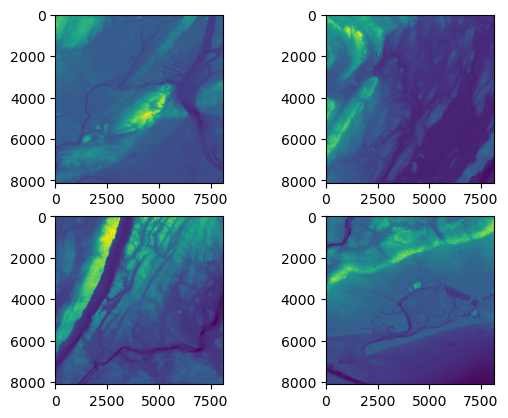

In [12]:
geom_rasters = [ocsmesh.Raster(i) for i in ny_cudem]

fig_2, axs_2 = plt.subplots(2, 2)
for ax, rast in zip(axs_2.ravel(), geom_rasters):
    ax.imshow(rast.get_values())
fig_2.show()

Now let's use these rasters to create geometry:

### Collection geometry

## Size function
### Mesh based
### Raster based
## Mesh
### Parsers
## Tools
### Raster manipulation
### Mesh object manipulation

['naturalearth_cities', 'naturalearth_lowres', 'nybb']